Hand Gestures

Import Necessary Libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_dir = r"C:\Users\kdine\Desktop\prodigy\Task-4\HandGestureRecognition\train"
test_dir = r"C:\Users\kdine\Desktop\prodigy\Task-4\HandGestureRecognition\test"
classes = os.listdir(train_dir)

In [3]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(40),              # resize shortest side
        transforms.CenterCrop(40),          # crop longest side
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [4]:
dataset = ImageFolder(train_dir, transform=train_transform)
testset = ImageFolder(test_dir, transform=train_transform)
print(len(dataset))

18000


In [5]:
# function for the showing the image.
def show_image(img,label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  train (0)


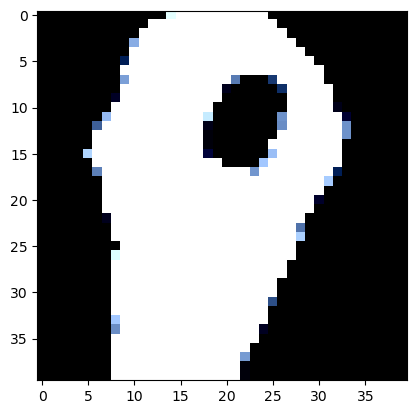

In [6]:
show_image(*dataset[15])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  train (0)


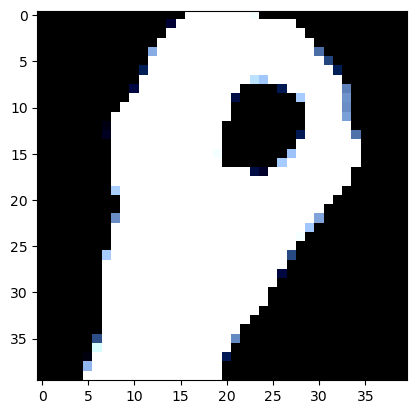

In [7]:
show_image(*dataset[20])

In [8]:
torch.manual_seed(10)
val_size=len(dataset)//5
train_size=len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
test_ds = testset
len(train_ds), len(val_ds), len(test_ds) 

(14400, 3600, 6000)

In [9]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)
#data_loader = DataLoader(dataset, batch_size, shuffle=None, num_workers=4, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


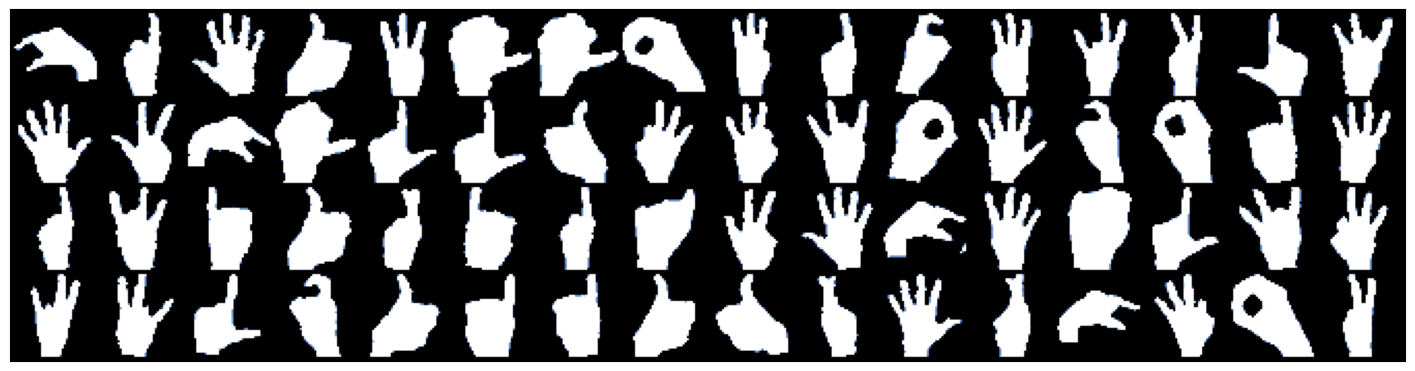

In [10]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [12]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [13]:
torch.cuda.is_available()

False

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cpu')

In [16]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
#data_loader = DeviceDataLoader(data_loader, device)

In [17]:
input_size = 3*40*40
output_size = 3

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                   # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [19]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(6250, 256),  
            nn.ReLU(),            
            nn.Linear(256, 128),  
            nn.ReLU(),            
            nn.Linear(128, 64),           
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(32, len(classes)))
        
    def forward(self, xb):
        return self.network(xb)

In [21]:
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=6250, out_features=256, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [22]:
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 40, 40])
out.shape: torch.Size([64, 1])
out[0]: tensor([-0.1219], grad_fn=<SelectBackward0>)


In [23]:
device = get_default_device()
device

device(type='cpu')

In [24]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)
to_device(model, device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=6250, out_features=256, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [25]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
model = to_device(CnnModel(), device)

In [27]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 0.0, 'val_acc': 1.0}]

In [28]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000


  0%|          | 0/225 [00:00<?, ?it/s]

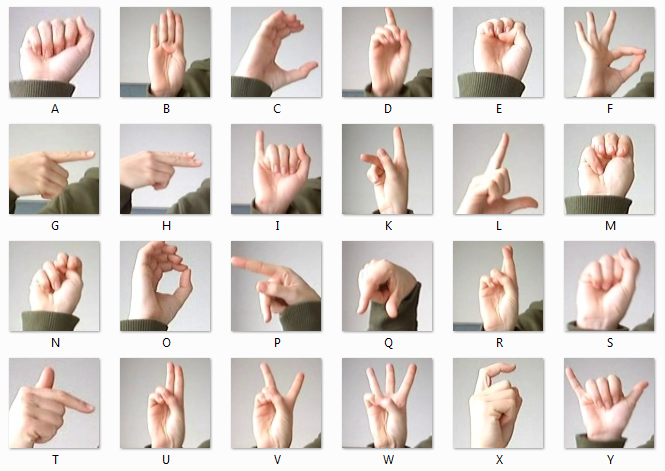

In [2]:
# one-to-one map for each alphabetic letter A-Z 

from IPython.display import Image
Image(filename=r"C:\Users\kdine\Desktop\prodigy\Task-4\Sign-Language-master\Sign-Language-master\amer_sign2.png", width= 800, height=500)

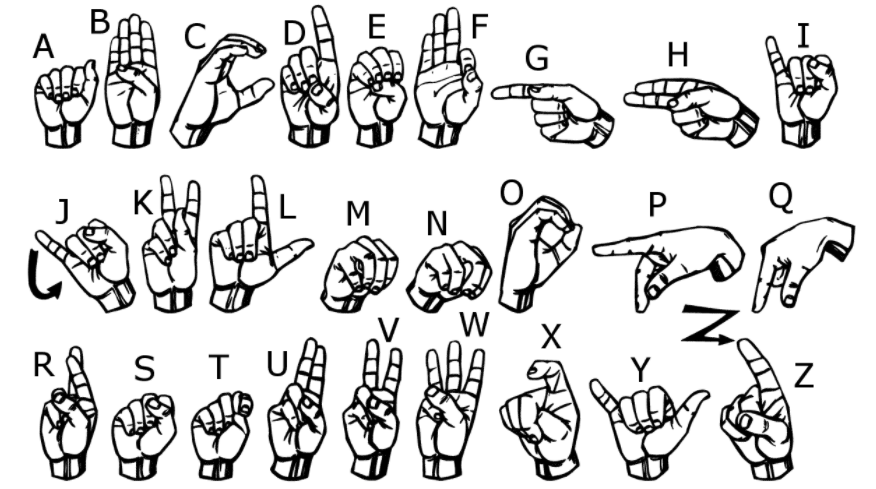

In [3]:
# one-to-one map for each alphabetic letter A-Z 

from IPython.display import Image
Image(filename=r"C:\Users\kdine\Desktop\prodigy\Task-4\Sign-Language-master\Sign-Language-master\american_sign_language.PNG", width= 800, height=500)

In [4]:
#importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")
from sklearn import metrics 
from sklearn.decomposition import PCA

1. Loading Data

In [5]:
#Loading traning data into dataframe

train_dataframe = pd.read_csv(r"C:\Users\kdine\Desktop\prodigy\Task-4\Sign-Language-master\Sign-Language-master\sign_mnist_train.csv")

In [6]:
#Loading testing data into dataframe

test_dataframe = pd.read_csv(r"C:\Users\kdine\Desktop\prodigy\Task-4\Sign-Language-master\Sign-Language-master\sign_mnist_test.csv")

2. Familiarizing with Data

In [7]:
#checking first 5 instances of dataframe

train_dataframe.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [8]:
#Shape of dataframe

train_dataframe.shape

(27455, 785)

In [9]:
#checking the data for null or missing values

train_dataframe.isna().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [10]:
# checking info of dataframe

train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [11]:
# checking unique value in dataset

labels=train_dataframe.label.unique()
np.sort(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

In [12]:
# describtion of dataset

train_dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
label,27455.0,12.318813,7.287552,0.0,6.0,13.0,19.0,24.0
pixel1,27455.0,145.419377,41.358555,0.0,121.0,150.0,174.0,255.0
pixel2,27455.0,148.500273,39.942152,0.0,126.0,153.0,176.0,255.0
pixel3,27455.0,151.247714,39.056286,0.0,130.0,156.0,178.0,255.0
pixel4,27455.0,153.546531,38.595247,0.0,133.0,158.0,179.0,255.0
...,...,...,...,...,...,...,...,...
pixel780,27455.0,162.736696,63.444008,0.0,125.0,184.0,207.0,255.0
pixel781,27455.0,162.906137,63.509210,0.0,128.0,184.0,207.0,255.0
pixel782,27455.0,161.966454,63.298721,0.0,128.0,182.0,206.0,255.0
pixel783,27455.0,161.137898,63.610415,0.0,128.0,182.0,204.0,255.0


In [13]:
#checking first 5 instances of dataframe

test_dataframe.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [14]:
#Shape of dataframe

test_dataframe.shape

(7172, 785)

In [15]:
# checking info of dataframe

test_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 43.0 MB


In [16]:
#checking the data for null or missing values

test_dataframe.isna().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [17]:
# describtion of dataset

test_dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
label,7172.0,11.247351,7.446712,0.0,4.00,11.0,18.0,24.0
pixel1,7172.0,147.532627,43.593144,0.0,122.00,154.0,178.0,255.0
pixel2,7172.0,150.445761,41.867838,0.0,126.00,157.0,179.0,255.0
pixel3,7172.0,153.324317,40.442728,0.0,130.00,159.0,181.0,255.0
pixel4,7172.0,155.663413,39.354776,0.0,134.00,161.0,182.0,255.0
...,...,...,...,...,...,...,...,...
pixel780,7172.0,159.648494,65.499368,0.0,113.75,182.0,208.0,255.0
pixel781,7172.0,158.162019,66.493576,0.0,113.00,181.0,207.0,255.0
pixel782,7172.0,157.672755,66.009690,0.0,115.00,180.0,205.0,255.0
pixel783,7172.0,156.664250,67.202939,0.0,111.00,180.0,206.0,255.0


3. Converting the pandas Dataframe into Numpy Arrays

In [18]:
# Converting the pandas Dataframe into Numpy Arrays

inputs_array_train = train_dataframe.iloc[:, 1:].to_numpy()
targets_array_train = train_dataframe['label'].to_numpy()
inputs_array_test = test_dataframe.iloc[:, 1:].to_numpy()
targets_array_test = test_dataframe['label'].to_numpy()

4. Visualizing the data

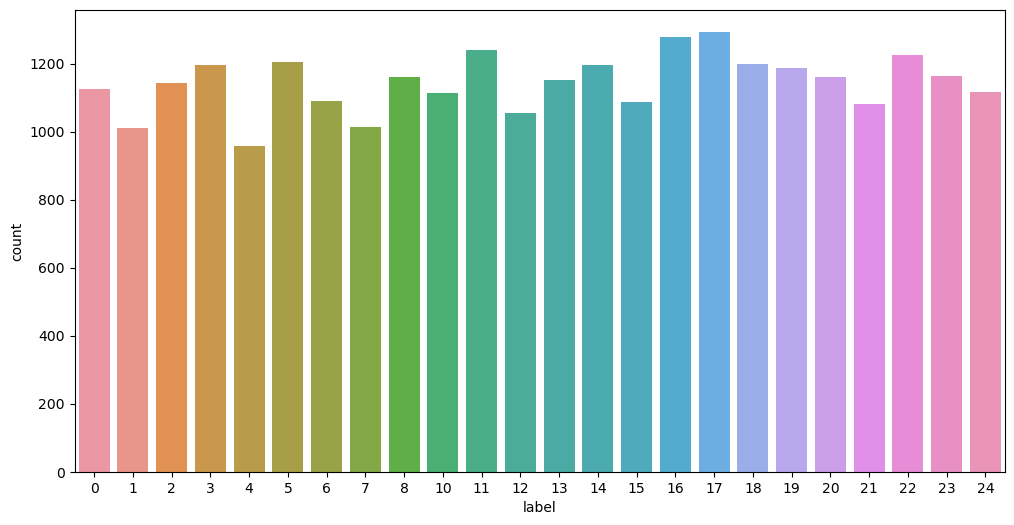

In [19]:
#Label Count Bar Plot

plt.figure(figsize=(12,6))
sns.countplot(x="label",data=train_dataframe);

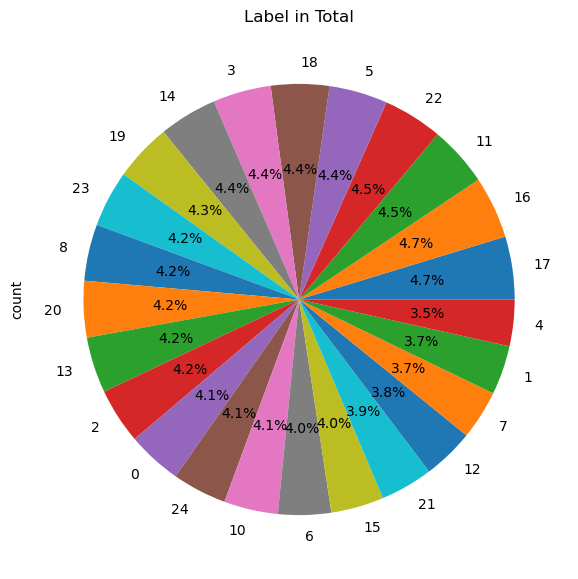

In [20]:
#pie chart for Percentage of Label in total

train_dataframe['label'].value_counts().plot(kind='pie',autopct='%1.1f%%',figsize=(7,7))
plt.title("Label in Total")
plt.show()

In [21]:
# Defining Fuction for Displaying Train Image

def Show_Train_Image(row):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,10))
    fig.figsize=(1,1)
    img =np.reshape(inputs_array_train[row], (28, 28))
    print("Actual Label : ",chr(ord('A')+targets_array_train[row]))
    ax1.set_title("Original Image")
    ax1.axis("off")
    ax1.imshow(img);
    ax2.axis("off")
    ax2.set_title("Gray Image")
    ax2.imshow(img,cmap='gray');


# Defining Fuction for Displaying Test Image 

def Show_Test_Image(row,y_test):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,10))
    fig.figsize=(1,1)
    img =np.reshape(inputs_array_train[row], (28, 28))
    print("Actual Label : ",chr(ord('A')+targets_array_train[row]))
    print("Predicted Label : ",chr(ord('A')+y_test[row]))
    ax1.set_title("Original Image")
    ax1.axis("off")
    ax1.imshow(img);
    ax2.axis("off")
    ax2.set_title("Gray Image")
    ax2.imshow(img,cmap='gray');

Actual Label :  H


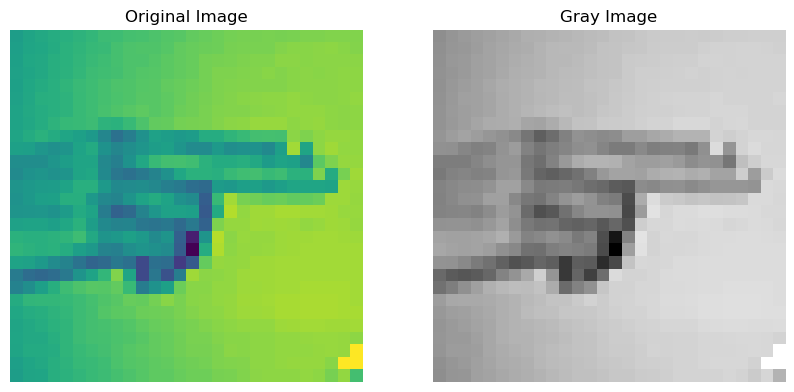

In [22]:
# showing training Image

Show_Train_Image(345)

Actual Label :  D


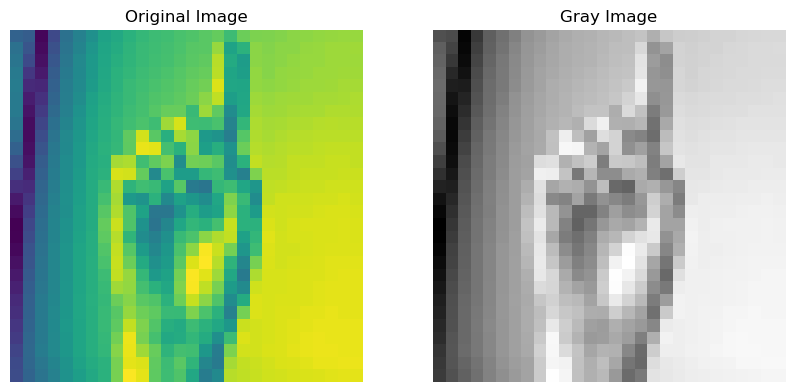

In [23]:
# showing training Image

Show_Train_Image(3256)

5. Data Preprocessing & EDA

In [24]:
# Normlization of datasets

X_train=inputs_array_train/255
X_test=inputs_array_test/255

y_train = targets_array_train  
y_test  = targets_array_test

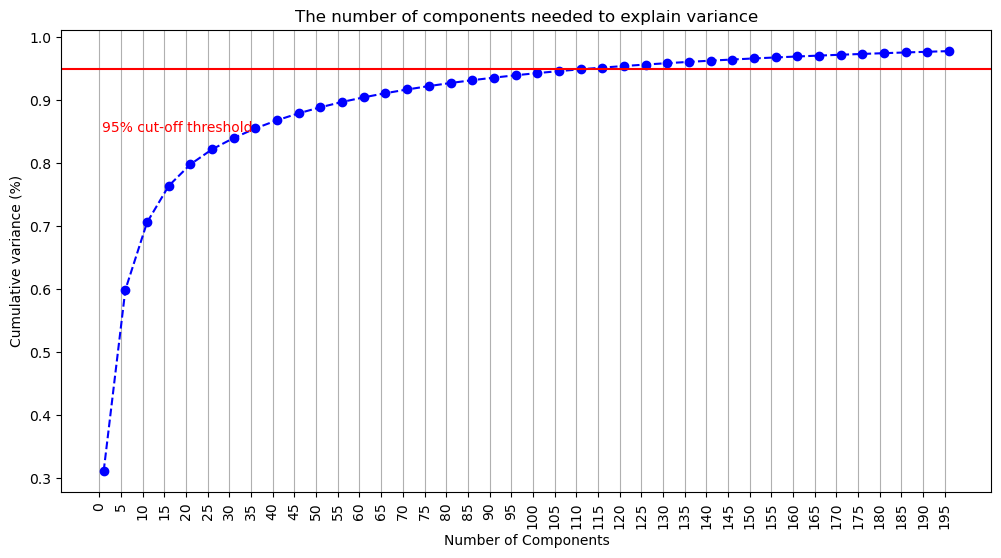

The number of components needed to explain variance :  113


In [25]:
# Calculating n_component value for PCA

pca = PCA().fit(X_train)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
x = np.arange(1, 785, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.plot(x[:200:5], y[:200:5], marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 200, step=5),rotation=90)
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red')

ax.grid(axis='x')
plt.show()

for i,j in zip(x,y):
    if(j>0.95):
        print('The number of components needed to explain variance : ',i)
        break
    

6. Model Building & Training:

In [26]:
# Creating holders to store the model performance results
ML_Model = []
acc_train = []
acc_test = []

#function to call for storing the results
def storeResults(model, a,b):
  ML_Model.append(model)
  acc_train.append(round(a, 3))
  acc_test.append(round(b, 3))

6.1. Logistic Regression

In [27]:
# Linear regression model 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# instantiate the model
log = Pipeline([('reduce_dims', PCA(n_components=113)),
                ('model', LogisticRegression(multi_class="multinomial" ,random_state = 0))])

# fit the model 
log.fit(X_train,y_train)

Pipeline(steps=[('reduce_dims', PCA(n_components=113)),
                ('model',
                 LogisticRegression(multi_class='multinomial',
                                    random_state=0))])

In [28]:
#predicting the target value from the model for the samples

y_train_log = log.predict(X_train)
y_test_log = log.predict(X_test)

Performance Evaluation:

In [29]:
#computing the accuracy of the model performance
acc_train_log = metrics.accuracy_score(y_train,y_train_log)
acc_test_log = metrics.accuracy_score(y_test,y_test_log)

print("Logistic Regression : Accuracy on training Data: {:.3f}".format(acc_train_log))
print("Logistic Regression: Accuracy on test Data: {:.3f}".format(acc_test_log))

Logistic Regression : Accuracy on training Data: 0.999
Logistic Regression: Accuracy on test Data: 0.684


In [30]:
#computing the classification report of the model

print(metrics.classification_report(y_test, y_test_log))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       331
           1       1.00      0.83      0.91       432
           2       0.89      0.93      0.91       310
           3       0.83      0.71      0.77       245
           4       0.89      0.91      0.90       498
           5       0.59      0.91      0.72       247
           6       0.86      0.72      0.79       348
           7       0.86      0.67      0.75       436
           8       0.74      0.72      0.73       288
          10       0.53      0.32      0.40       331
          11       0.54      0.90      0.68       209
          12       0.65      0.62      0.63       394
          13       0.70      0.53      0.61       291
          14       0.99      0.66      0.79       246
          15       0.90      0.94      0.92       347
          16       0.55      0.74      0.63       164
          17       0.19      0.46      0.27       144
          18       0.31    

<Figure size 1000x1000 with 0 Axes>

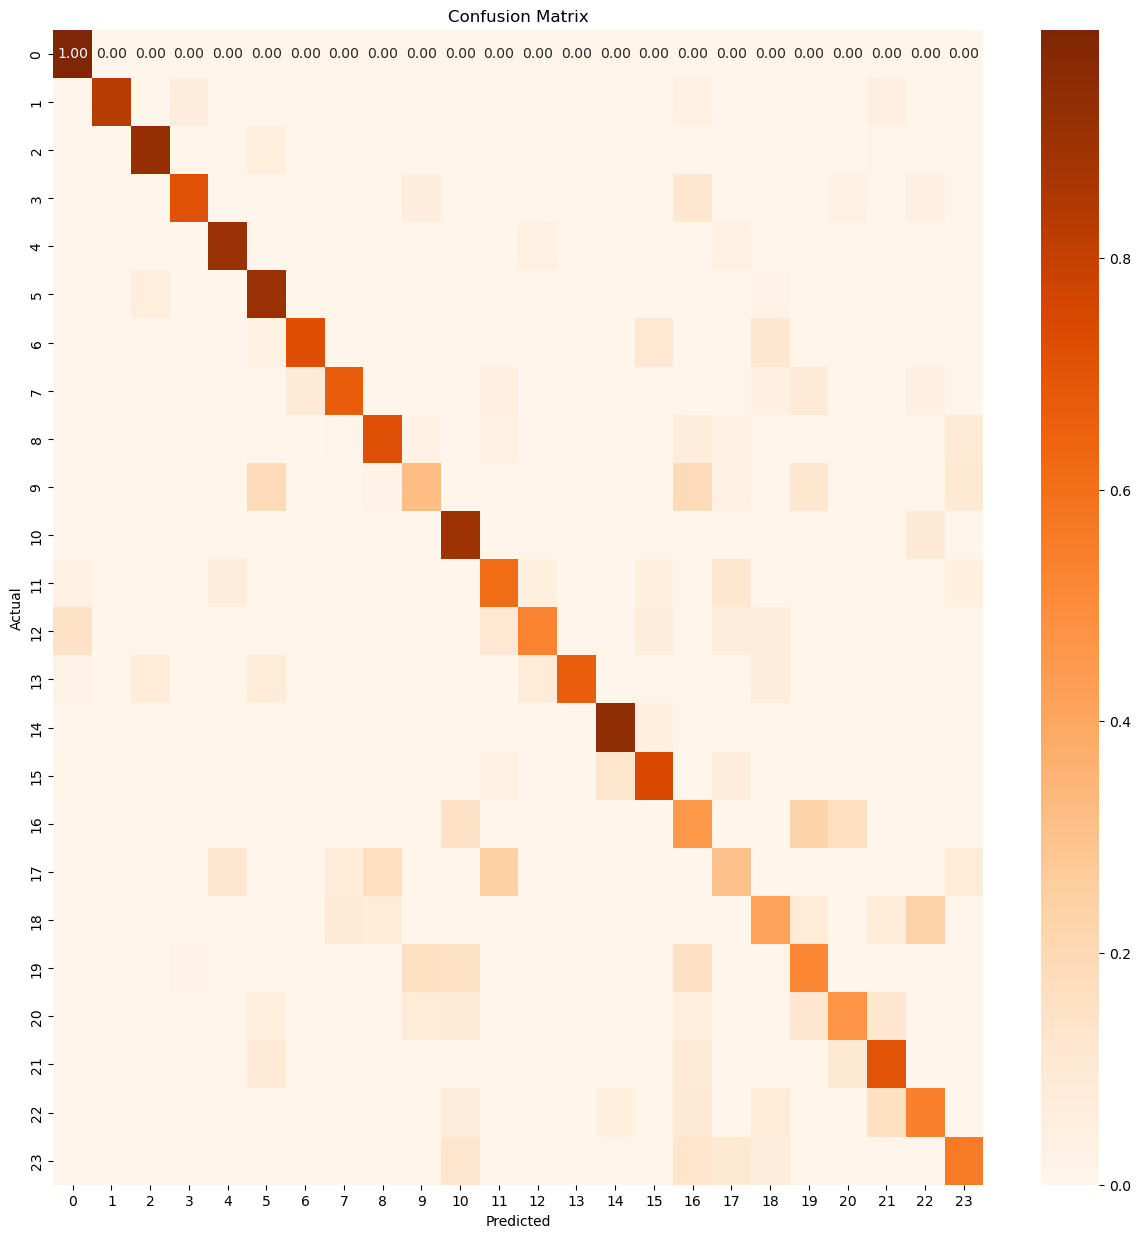

In [31]:
plt.figure(figsize=(10,10))
cm=metrics.confusion_matrix(y_test,y_test_log)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cmn, annot=True, fmt='.2f',cmap='Oranges')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False);

In [32]:
#storing the results. The below mentioned order of parameter passing is important.
storeResults('Logistic Regression',acc_train_log, acc_test_log)

Actual Label :  N
Predicted Label :  F


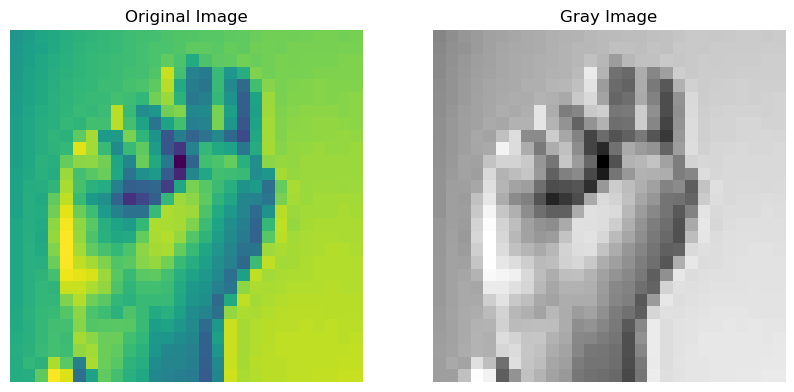

In [34]:
# Checking Image for Actual and Preicted Label
Show_Test_Image(3252,y_test_log)

Actual Label :  C
Predicted Label :  P


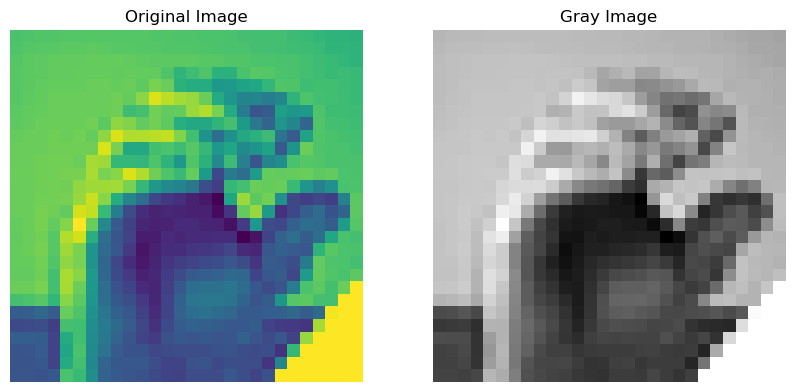

In [35]:
# Checking Image for Actual and Preicted Label
Show_Test_Image(246,y_test_log)

6.2. Decision Trees : Classifier

In [38]:
# Decision Tree Classifier model 
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# instantiate the model 
tree = Pipeline([('reduce_dims', PCA(n_components=113)),
                 ('model', DecisionTreeClassifier(max_depth=30))])

# fit the model 
tree.fit(X_train, y_train)

Pipeline(steps=[('reduce_dims', PCA(n_components=113)),
                ('model', DecisionTreeClassifier(max_depth=30))])

In [39]:
#predicting the target value from the model for the samples

y_train_tree = tree.predict(X_train)
y_test_tree = tree.predict(X_test)

Performance Evaluation:

In [40]:
#computing the accuracy of the model performance
acc_train_tree = metrics.accuracy_score(y_train,y_train_tree)
acc_test_tree = metrics.accuracy_score(y_test,y_test_tree)


print("Decision Tree : Accuracy on training Data: {:.3f}".format(acc_train_tree))
print("Decision Tree : Accuracy on test Data: {:.3f}".format(acc_test_tree))

Decision Tree : Accuracy on training Data: 0.995
Decision Tree : Accuracy on test Data: 0.400


In [41]:
#computing the classification report of the model

print(metrics.classification_report(y_test, y_test_tree))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69       331
           1       0.53      0.65      0.58       432
           2       0.74      0.56      0.64       310
           3       0.33      0.50      0.40       245
           4       0.60      0.40      0.48       498
           5       0.49      0.57      0.53       247
           6       0.46      0.52      0.49       348
           7       0.62      0.63      0.62       436
           8       0.20      0.29      0.24       288
          10       0.24      0.12      0.16       331
          11       0.47      0.52      0.49       209
          12       0.34      0.22      0.26       394
          13       0.17      0.18      0.18       291
          14       0.39      0.40      0.40       246
          15       0.82      0.53      0.64       347
          16       0.42      0.46      0.44       164
          17       0.17      0.42      0.24       144
          18       0.23    

<Figure size 1000x1000 with 0 Axes>

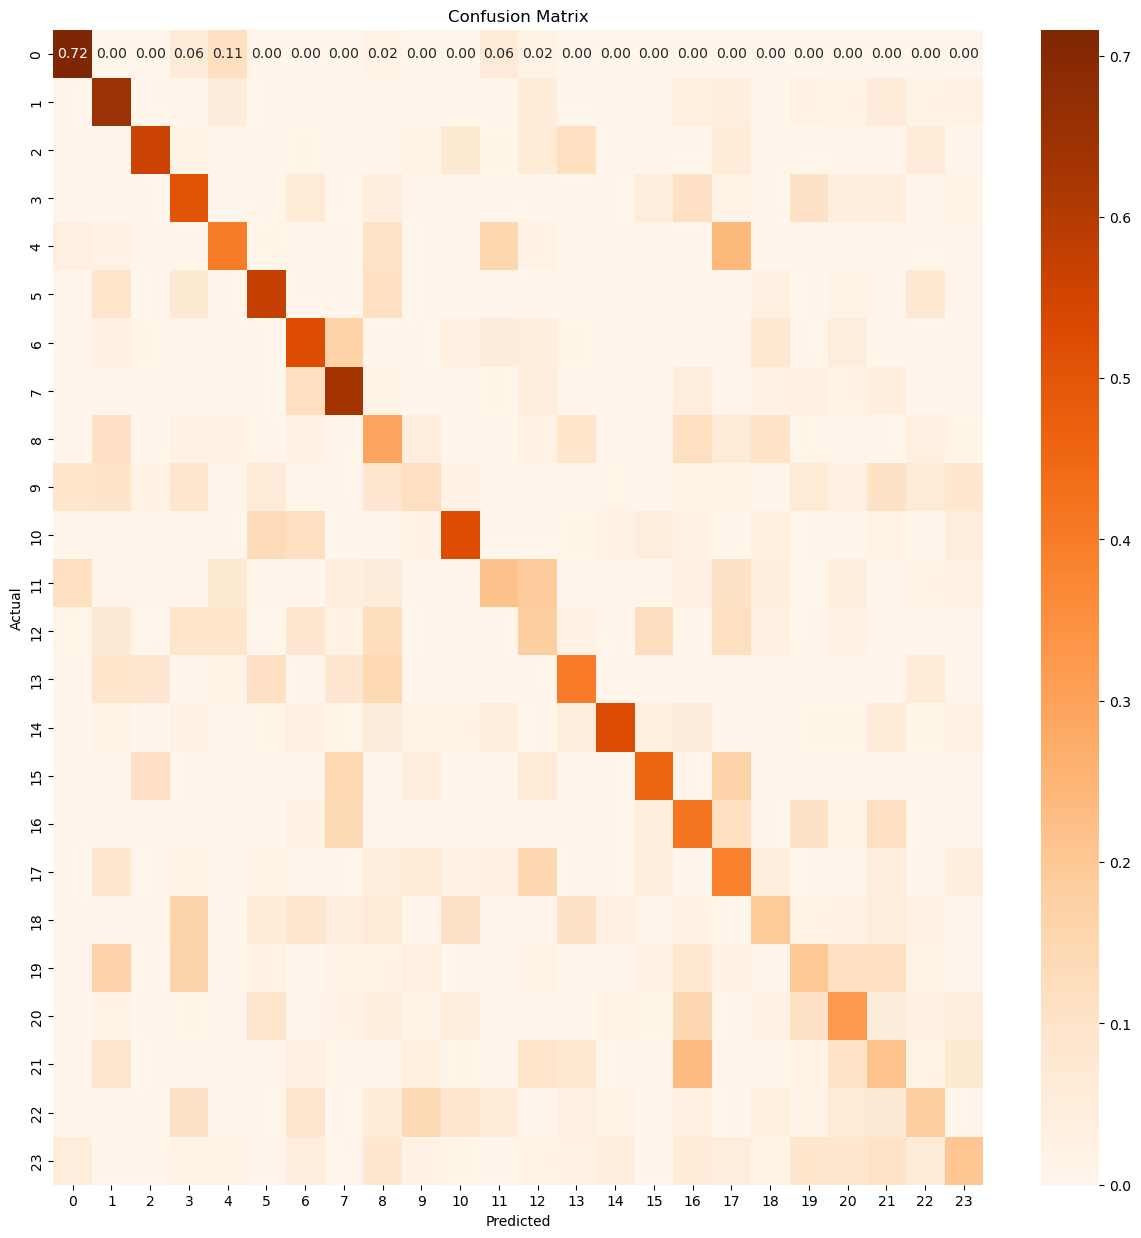

In [42]:
#visualization of Confusion Matrix 

plt.figure(figsize=(10,10))
cm=metrics.confusion_matrix(y_test,y_test_tree)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cmn, annot=True, fmt='.2f',cmap='Oranges')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False);

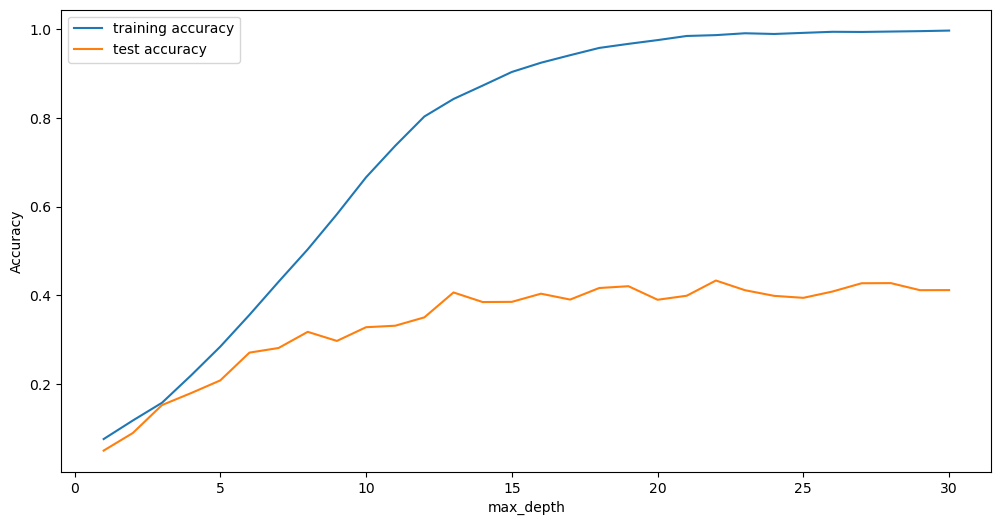

In [43]:
training_accuracy = []
test_accuracy = []
# try max_depth from 1 to 30
depth = range(1,31)
for n in depth:
    tree_test = Pipeline([('reduce_dims', PCA(n_components=113)),
                    ('model', DecisionTreeClassifier(max_depth=n))])

    tree_test.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(tree_test.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(tree_test.score(X_test, y_test))
    

#plotting the training & testing accuracy for max_depth from 1 to 30
plt.plot(depth, training_accuracy, label="training accuracy")
plt.plot(depth, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")  
plt.xlabel("max_depth")
plt.legend();

In [44]:
#storing the results. The below mentioned order of parameter passing is important.
storeResults('Decision Tree',acc_train_tree, acc_test_tree)

Actual Label :  C
Predicted Label :  D


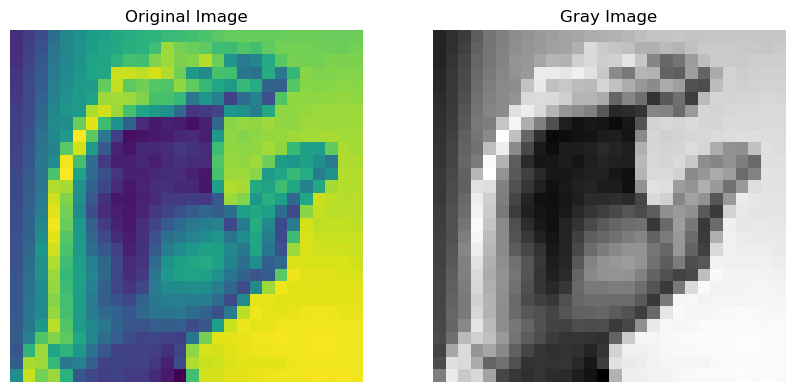

In [45]:
# Checking Image for Actual and Preicted Label
Show_Test_Image(3253,y_test_tree)

Actual Label :  R
Predicted Label :  B


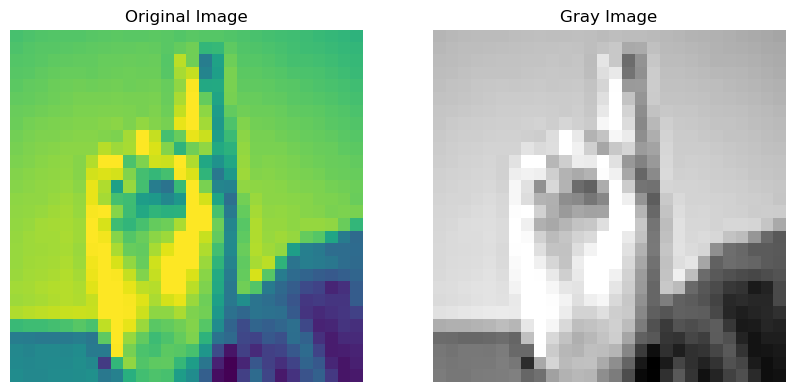

In [46]:
# Checking Image for Actual and Preicted Label
Show_Test_Image(2356,y_test_tree)

6.3. Support Vector Machine : Classifier

In [47]:
# Support Vector Classifier model 
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# instantiate the model
svc= Pipeline([('reduce_dims', PCA(n_components=113)),('model', SVC())])

# fit the model 
svc.fit(X_train,y_train)

Pipeline(steps=[('reduce_dims', PCA(n_components=113)), ('model', SVC())])

In [48]:
#predicting the target value from the model for the samples
y_train_svc = svc.predict(X_train)
y_test_svc = svc.predict(X_test)

In [49]:
#computing the accuracy of the model performance
acc_train_svc = metrics.accuracy_score(y_train,y_train_svc)
acc_test_svc = metrics.accuracy_score(y_test,y_test_svc)

print("Support Vector Machine : Accuracy on training Data: {:.3f}".format(acc_train_svc))
print("Support Vector Machine : Accuracy on test Data: {:.3f}".format(acc_test_svc))

Support Vector Machine : Accuracy on training Data: 1.000
Support Vector Machine : Accuracy on test Data: 0.853


In [50]:
#computing the classification report of the model

print(metrics.classification_report(y_test, y_test_svc))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       331
           1       1.00      0.99      1.00       432
           2       0.87      0.99      0.93       310
           3       0.93      1.00      0.96       245
           4       0.94      0.99      0.97       498
           5       0.74      0.83      0.79       247
           6       0.94      0.91      0.92       348
           7       0.97      0.94      0.96       436
           8       0.82      0.91      0.86       288
          10       0.82      0.67      0.74       331
          11       0.88      0.97      0.92       209
          12       0.86      0.74      0.79       394
          13       0.90      0.68      0.77       291
          14       0.97      0.85      0.90       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00       164
          17       0.34      0.62      0.44       144
          18       0.70    

<Figure size 1000x1000 with 0 Axes>

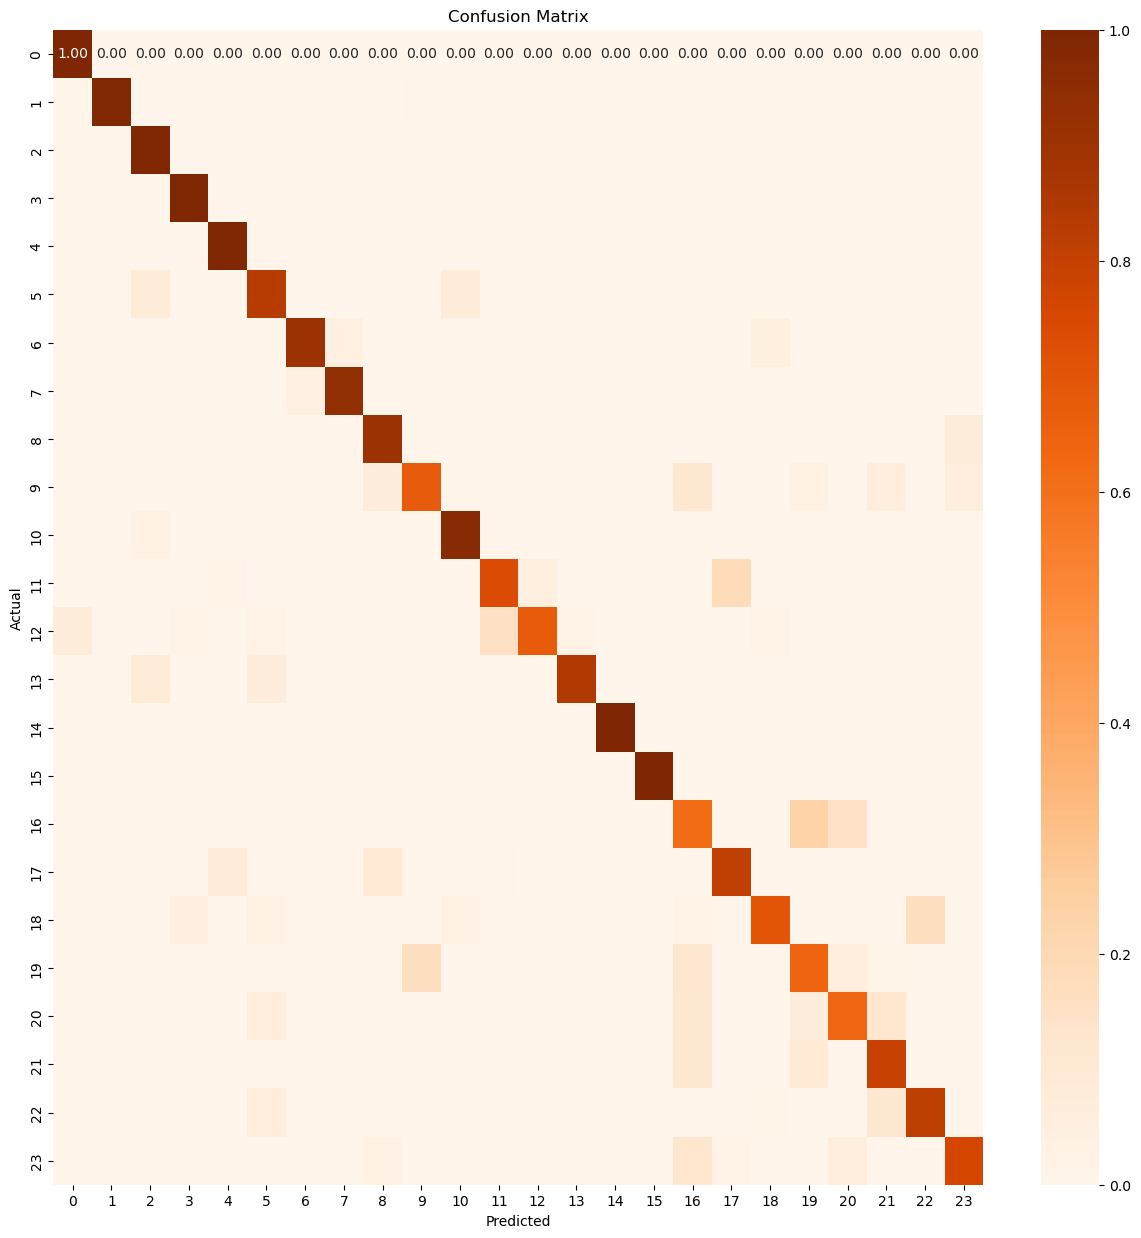

In [51]:
#visualization of Confusion Matrix 

plt.figure(figsize=(10,10))
cm=metrics.confusion_matrix(y_test,y_test_svc)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cmn, annot=True, fmt='.2f',cmap='Oranges')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False);

In [52]:
#storing the results. The below mentioned order of parameter passing is important.
storeResults('Support Vector Machine',acc_train_svc, acc_test_svc)

Actual Label :  V
Predicted Label :  M


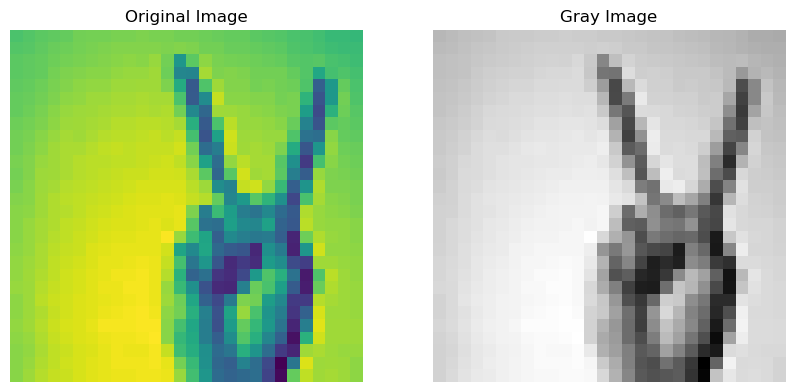

In [53]:
# Checking Image for Actual and Preicted Label
Show_Test_Image(1214,y_test_svc)

Actual Label :  H
Predicted Label :  I


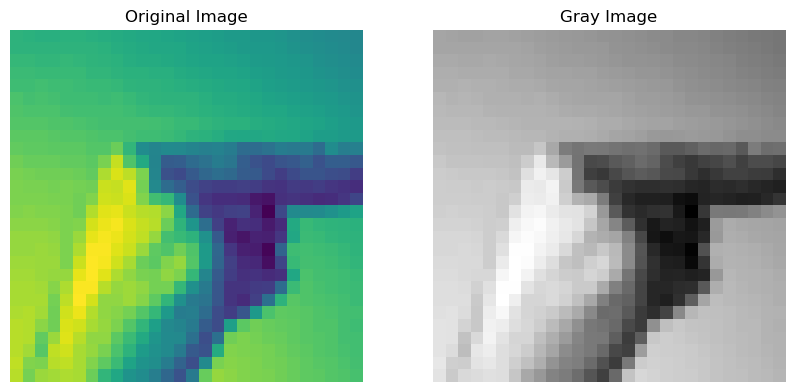

In [54]:
# Checking Image for Actual and Preicted Label
Show_Test_Image(3233,y_test_svc)

6.4. Random Forest : Classifier

In [55]:
# Random Forest Classifier Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# instantiate the model
forest = Pipeline([('reduce_dims', PCA(n_components=113)),
                ('model', RandomForestClassifier(n_estimators=100))])

# fit the model 
forest.fit(X_train,y_train)

Pipeline(steps=[('reduce_dims', PCA(n_components=113)),
                ('model', RandomForestClassifier())])

In [56]:
#predicting the target value from the model for the samples
y_train_forest = forest.predict(X_train)
y_test_forest = forest.predict(X_test)

In [57]:
#computing the accuracy of the model performance
acc_train_forest = metrics.accuracy_score(y_train,y_train_forest)
acc_test_forest = metrics.accuracy_score(y_test,y_test_forest)

print("Random Forest : Accuracy on training Data: {:.3f}".format(acc_train_forest))
print("Random Forest : Accuracy on test Data: {:.3f}".format(acc_test_forest))

Random Forest : Accuracy on training Data: 1.000
Random Forest : Accuracy on test Data: 0.770


In [58]:
print(metrics.classification_report(y_test, y_test_forest))

              precision    recall  f1-score   support

           0       0.84      1.00      0.92       331
           1       0.96      0.91      0.93       432
           2       0.97      0.95      0.96       310
           3       0.81      0.92      0.86       245
           4       0.90      0.92      0.91       498
           5       0.82      0.91      0.87       247
           6       0.80      0.85      0.83       348
           7       0.93      0.90      0.92       436
           8       0.72      0.78      0.75       288
          10       0.66      0.56      0.61       331
          11       0.77      1.00      0.87       209
          12       0.68      0.57      0.62       394
          13       0.61      0.46      0.53       291
          14       0.87      0.78      0.83       246
          15       0.98      1.00      0.99       347
          16       0.91      0.90      0.90       164
          17       0.28      0.49      0.35       144
          18       0.49    

<Figure size 1000x1000 with 0 Axes>

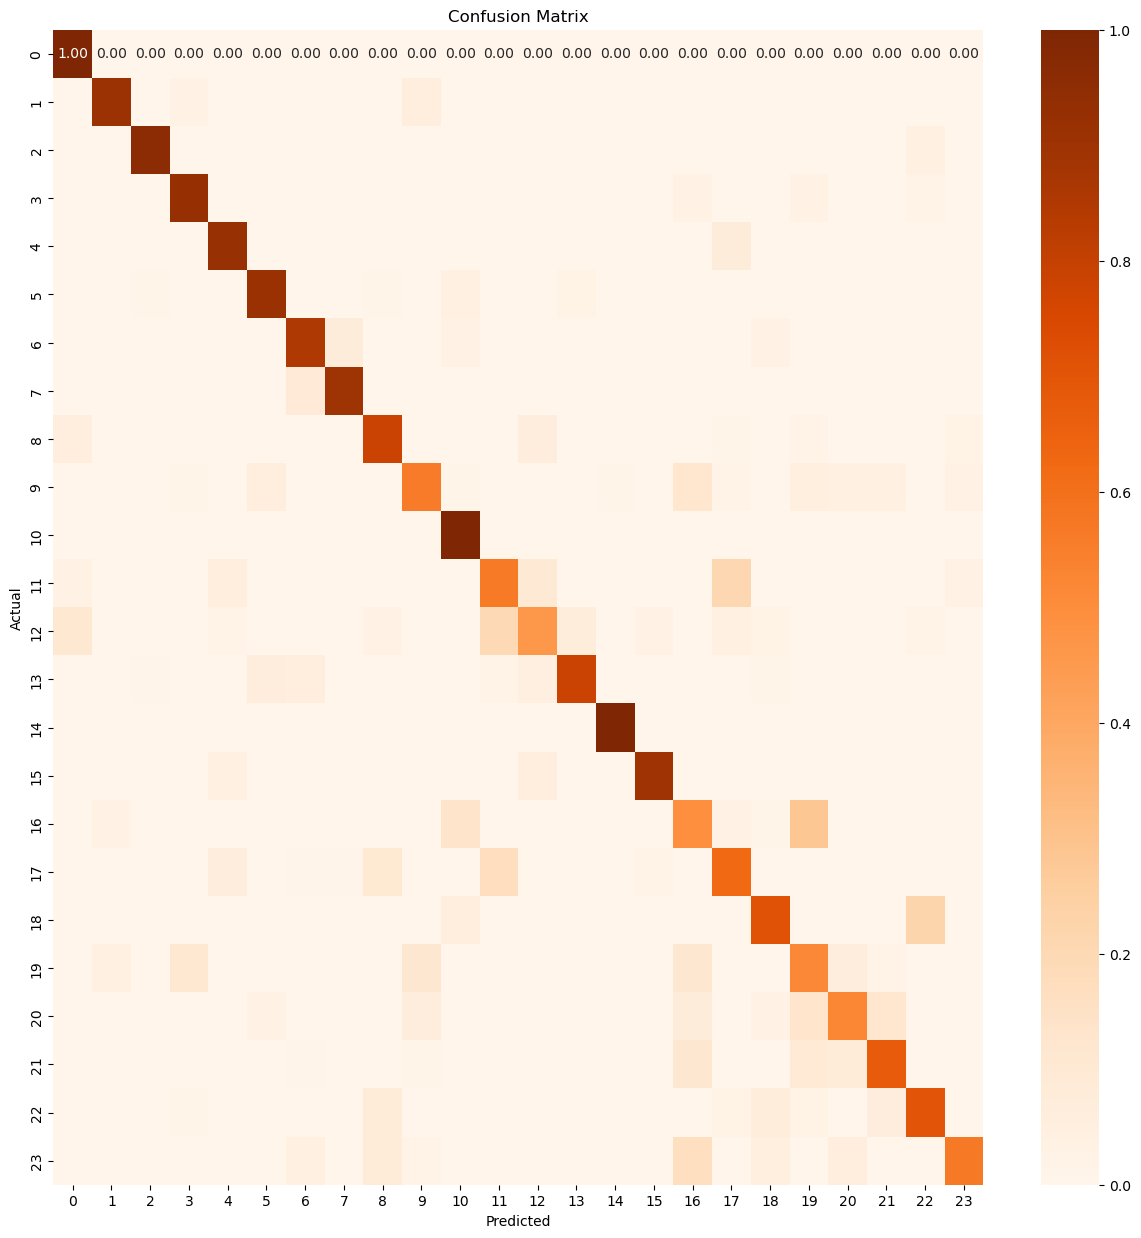

In [59]:
#visualization of Confusion Matrix 

plt.figure(figsize=(10,10))
cm=metrics.confusion_matrix(y_test,y_test_forest)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cmn, annot=True, fmt='.2f',cmap='Oranges')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False);

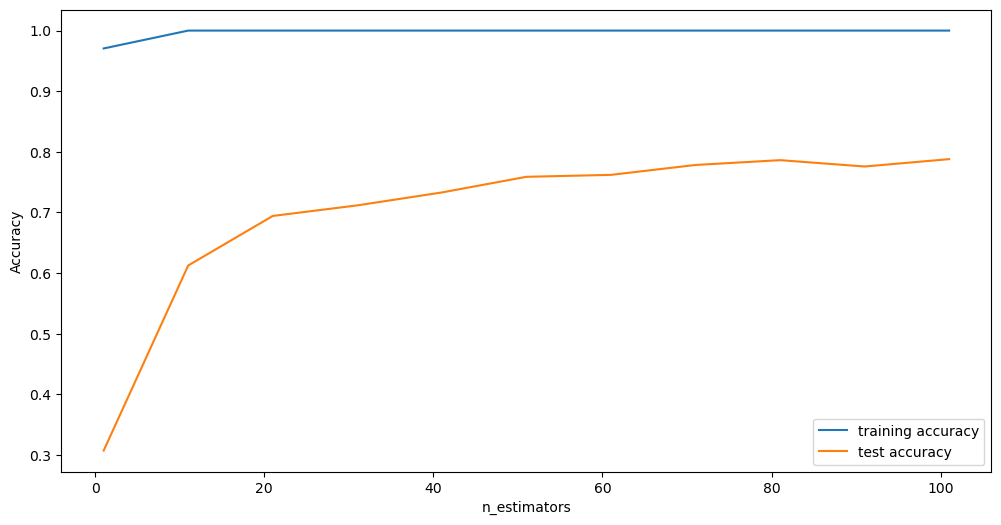

In [60]:
training_accuracy = []
test_accuracy = []
# try max_depth from 1 to 100
depth = range(1,102,10)
for n in depth:
    forest_test = Pipeline([('reduce_dims', PCA(n_components=113)),
                       ('model', RandomForestClassifier(n_estimators=n))])

    forest_test.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(forest_test.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(forest_test.score(X_test, y_test))
    

#plotting the training & testing accuracy for n_estimators from 1 to 100
plt.figure(figsize=None)
plt.plot(depth, training_accuracy, label="training accuracy")
plt.plot(depth, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")  
plt.xlabel("n_estimators")
plt.legend()

In [61]:
#storing the results. The below mentioned order of parameter passing is important.
storeResults('Random Forest',acc_train_forest, acc_test_forest)

Actual Label :  P
Predicted Label :  W


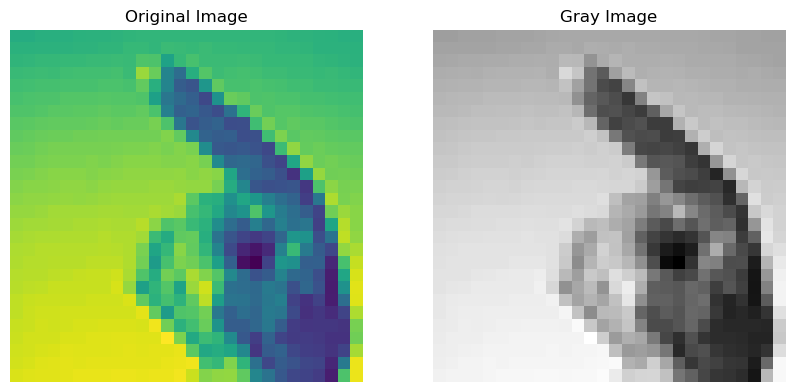

In [62]:
# Checking Image for Actual and Preicted Label
Show_Test_Image(6532,y_test_forest)

Actual Label :  C
Predicted Label :  N


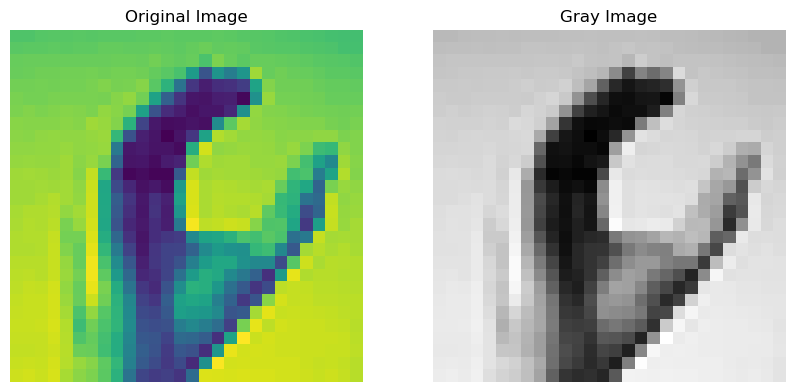

In [63]:
# Checking Image for Actual and Preicted Label
Show_Test_Image(32,y_test_forest)

6.5. Naive Bayes : Classifier

In [64]:
# Naive Bayes Classifier Model
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

# instantiate the model
nb= Pipeline([('reduce_dims', PCA(n_components=113)),('model', GaussianNB())])

# fit the model 
nb.fit(X_train,y_train)

Pipeline(steps=[('reduce_dims', PCA(n_components=113)),
                ('model', GaussianNB())])

In [65]:
#predicting the target value from the model for the samples
y_train_nb = nb.predict(X_train)
y_test_nb = nb.predict(X_test)

In [66]:
#computing the accuracy of the model performance
acc_train_nb =  metrics.accuracy_score(y_train,y_train_nb)
acc_test_nb =  metrics.accuracy_score(y_test,y_test_nb)

print("Naive Bayes : Accuracy on training Data: {:.3f}".format(acc_train_nb))
print("Naive Bayes : Accuracy on test Data: {:.3f}".format(acc_test_nb))

Naive Bayes : Accuracy on training Data: 0.796
Naive Bayes : Accuracy on test Data: 0.613


In [67]:
#computing the classification report of the model

print(metrics.classification_report(y_test, y_test_nb))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       331
           1       0.93      0.82      0.88       432
           2       1.00      0.75      0.85       310
           3       0.66      0.71      0.69       245
           4       0.85      0.67      0.75       498
           5       0.63      0.60      0.62       247
           6       0.84      0.63      0.72       348
           7       0.91      0.78      0.84       436
           8       0.69      0.51      0.59       288
          10       0.57      0.39      0.46       331
          11       0.76      0.85      0.80       209
          12       0.69      0.47      0.56       394
          13       0.36      0.30      0.32       291
          14       0.94      0.67      0.78       246
          15       0.71      0.51      0.60       347
          16       0.30      0.86      0.45       164
          17       0.19      0.64      0.29       144
          18       0.39    

<Figure size 1000x1000 with 0 Axes>

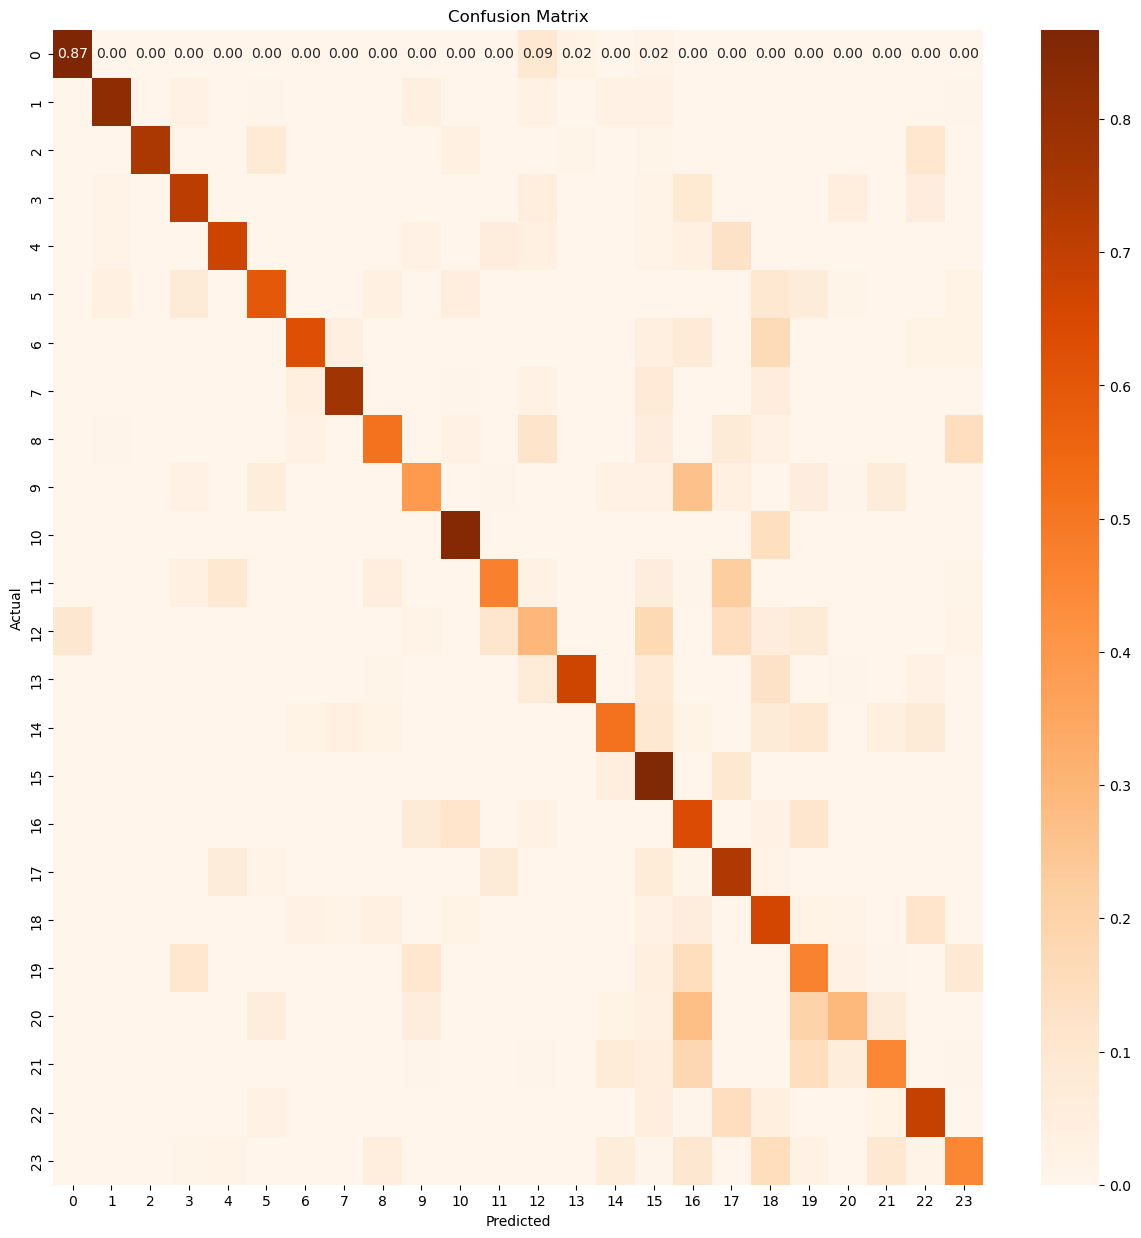

In [68]:
#visualization of Confusion Matrix 

plt.figure(figsize=(10,10))
cm=metrics.confusion_matrix(y_test,y_test_nb)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cmn, annot=True, fmt='.2f',cmap='Oranges')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False);

In [69]:
#storing the results. The below mentioned order of parameter passing is important.
storeResults('Naive Bayes',acc_train_nb, acc_test_nb)

Actual Label :  P
Predicted Label :  U


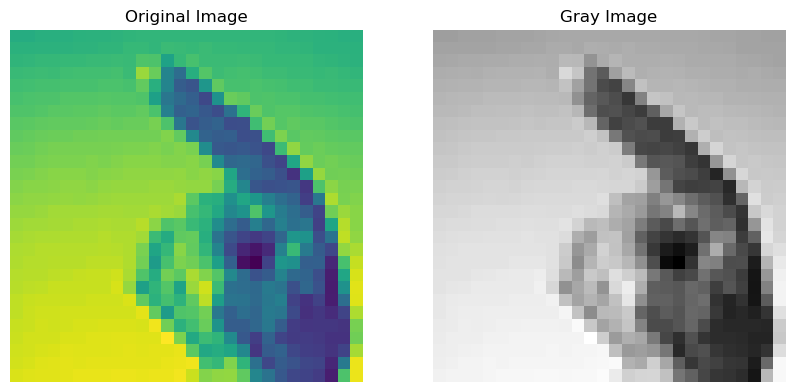

In [70]:
# Checking Image for Actual and Preicted Label
Show_Test_Image(6532,y_test_nb)

Actual Label :  X
Predicted Label :  P


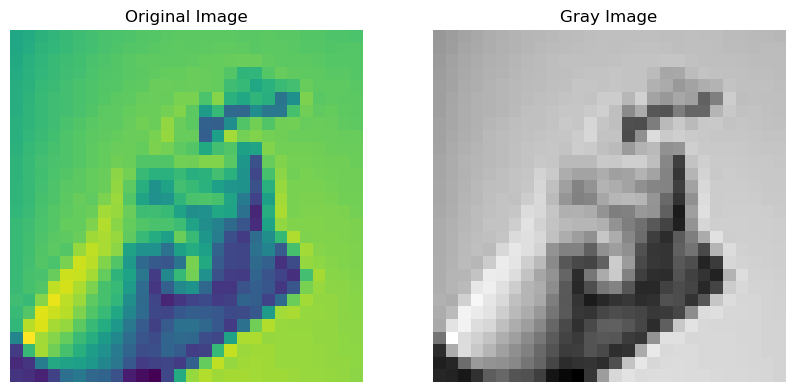

In [71]:
# Checking Image for Actual and Preicted Label
Show_Test_Image(25,y_test_nb)

6.6. K-Nearest Neighbors : Classifier

In [74]:
# K-Nearest Neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# instantiate the model
knn = Pipeline([('reduce_dims', PCA(n_components=113)),('model', KNeighborsClassifier())])

# fit the model 
knn.fit(X_train,y_train)

Pipeline(steps=[('reduce_dims', PCA(n_components=113)),
                ('model', KNeighborsClassifier())])

In [75]:
#predicting the target value from the model for the samples
y_train_knn = knn.predict(X_train)
y_test_knn = knn.predict(X_test)

In [76]:
#computing the accuracy of the model performance
acc_train_knn = metrics.accuracy_score(y_train,y_train_knn)
acc_test_knn = metrics.accuracy_score(y_test,y_test_knn)

print("K neighest neighbour : Accuracy on training Data: {:.3f}".format(acc_train_knn))
print("K neighest neighbour : Accuracy on test Data: {:.3f}".format(acc_test_knn))

K neighest neighbour : Accuracy on training Data: 0.999
K neighest neighbour : Accuracy on test Data: 0.815


In [77]:
#computing the classification report of the model

print(metrics.classification_report(y_test, y_test_knn))

              precision    recall  f1-score   support

           0       0.84      1.00      0.92       331
           1       0.95      0.92      0.93       432
           2       0.97      1.00      0.98       310
           3       0.75      0.94      0.83       245
           4       0.79      0.97      0.87       498
           5       0.89      0.93      0.91       247
           6       0.91      0.94      0.92       348
           7       0.96      0.95      0.95       436
           8       0.87      0.69      0.77       288
          10       0.86      0.59      0.70       331
          11       0.95      0.94      0.94       209
          12       0.80      0.51      0.62       394
          13       0.80      0.64      0.71       291
          14       1.00      0.93      0.96       246
          15       1.00      1.00      1.00       347
          16       0.93      1.00      0.96       164
          17       0.33      0.62      0.43       144
          18       0.67    

<Figure size 1000x1000 with 0 Axes>

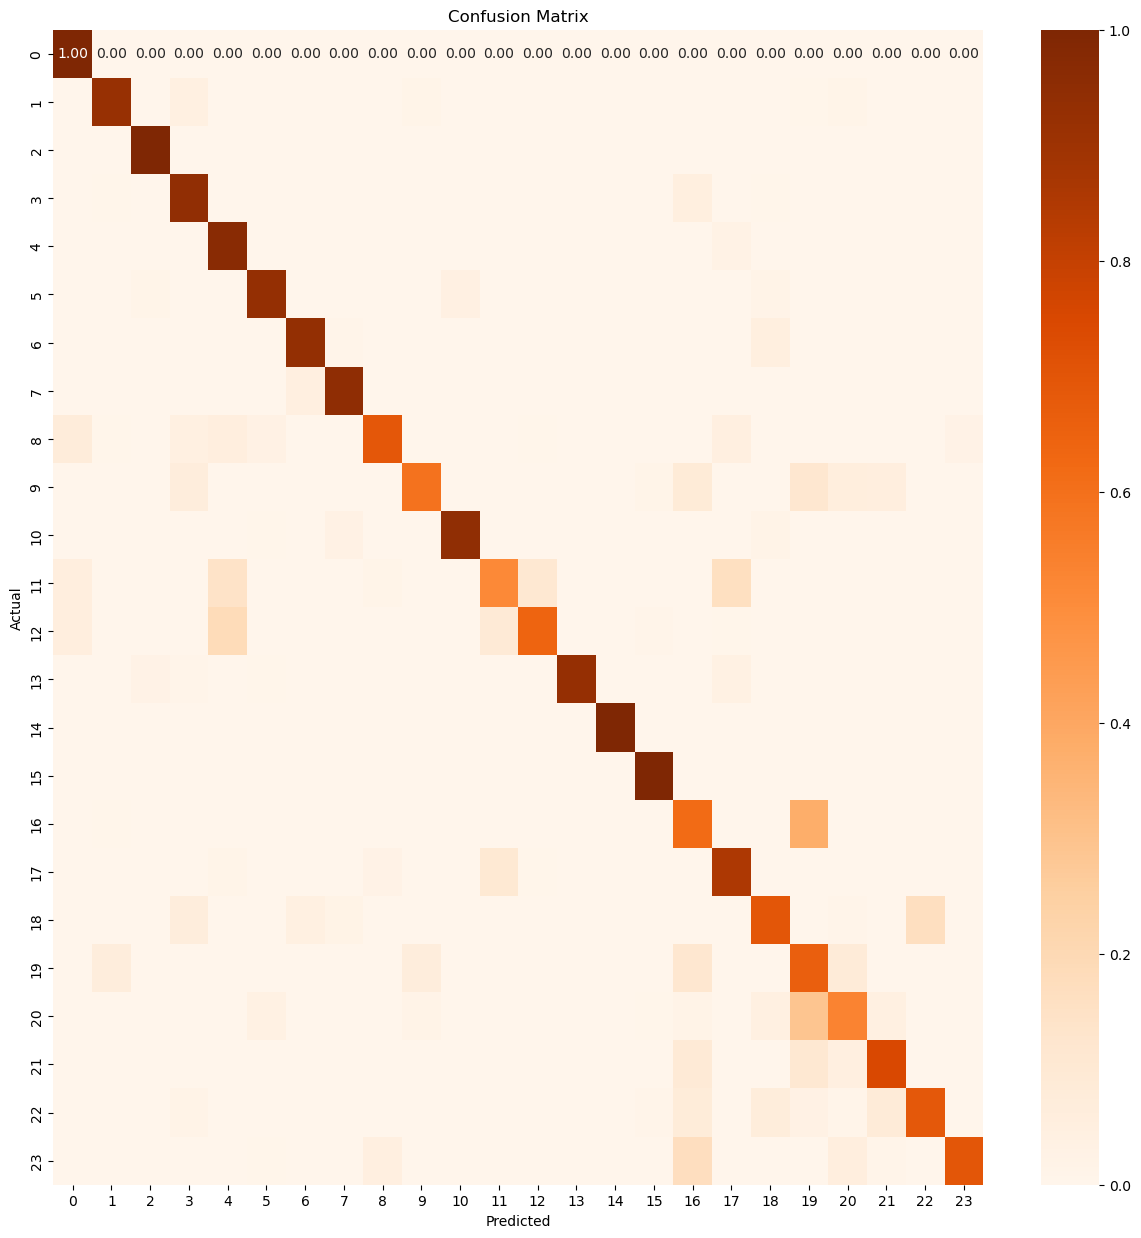

In [78]:
#visualization of Confusion Matrix 

plt.figure(figsize=(10,10))
cm=metrics.confusion_matrix(y_test,y_test_knn)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cmn, annot=True, fmt='.2f',cmap='Oranges')
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False);

In [ ]:
training_accuracy = []
test_accuracy = []
# try max_depth from 1 to 50
depth = range(1,52,5)
for n in depth:
    knn = Pipeline([('reduce_dims', PCA(n_components=113)),
                    ('model', KNeighborsClassifier(n_neighbors=n))])

    knn.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(knn.score(X_test, y_test))
    

#plotting the training & testing accuracy for n_estimators from 1 to 50
plt.plot(depth, training_accuracy, label="training accuracy")
plt.plot(depth, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")  
plt.xlabel("n_neighbors")
plt.legend()

In [ ]:
#storing the results. The below mentioned order of parameter passing is important.
storeResults('K-Nearest Neighbors',acc_train_knn, acc_test_knn)

In [ ]:
# Checking Image for Actual and Preicted Label
Show_Test_Image(632,y_test_knn)

In [ ]:
# Checking Image for Actual and Preicted Label
Show_Test_Image(5432,y_test_knn)

7. Comparision of Models:

In [ ]:
#creating dataframe
result = pd.DataFrame({ 'ML Model': ML_Model,
                        'Train Accuracy': acc_train,
                        'Test Accuracy': acc_test,})

In [ ]:
# dispalying total result
result

In [ ]:
#Sorting the datafram on accuracy
sorted_result=result.sort_values(by=['Test Accuracy', 'Train Accuracy'],ascending=False).reset_index(drop=True)

In [ ]:
# dispalying total result
sorted_result